In [1]:
import numpy as np
from pyLAMMPS import LAMMPS_setup
from pyLAMMPS.tools.general_utils import work_json
from pyLAMMPS.analysis.mechanical_properties import plot_deformation, get_stiffness_tensor, compute_VRH

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

********* JAX NOT FOUND *********
 PyMBAR can run faster with JAX  
 But will work fine without it   
Either install with pip or conda:
      pip install pybar[jax]     
               OR                
      conda install pymbar       
*********************************


## Mechanical properties

This notebook uses pyLAMMPS to setup simulations to compute mechanical properties using finite differences

In [2]:
lammps_setup = LAMMPS_setup( system_setup = "input/setup_mechanical.yaml", 
                             simulation_default = "input/defaults.yaml",
                             simulation_ensemble = "input/ensemble.yaml",
                             simulation_sampling = "input/sampling_mechanical.yaml",
                             submission_command = "qsub"
                            )

## Setting up equilibration

In this section the inital system is equilibrated at desired temperature and pressure.

1) Setup simulation


In [10]:
# Define the simulation folder
simulation_folder = "equilibration"

# Define the ensembles that should be simulated (definition what each ensemble means is provided in yaml file)
ensembles = [ "em", "npt" ] 

# Define the simulation time per ensemble in nano seconds (for em the number of iterations is provided in the ensemble yaml)
simulation_times = [ 0, 0.1 ]

# Define initial data file (for each pressure & temperature state one)
initial_systems = [ "/home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/input/ettringite_bulk.data" ]

# Define force field file
ff_file = "/home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/input/ettringite_bulk.params"

# Provide kwargs that should be passed into the input template directly
input_kwargs = {  }

# Define number of copies
copies = 2

# Define the starting number for the first ensemble ( 0{off_set}_ensemble )
off_set    = 0

lammps_setup.prepare_simulation( folder_name = simulation_folder, ensembles = ensembles, simulation_times = simulation_times,
                                 initial_systems = initial_systems, input_kwargs = input_kwargs, copies = copies,
                                 ff_file = ff_file, off_set = off_set )


Intial system provided for at: /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/input/ettringite_bulk.data



2) Submit jobs to cluster

In [11]:
# Submit the simulations
lammps_setup.submit_simulation()


Submitting simulations at Temperature = 298 K, Pressure = 1 bar

Submitting job: /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/equilibration/temp_298.1_pres_1.0/copy_0/job_298_1.sh
11365928


Submitting job: /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/equilibration/temp_298.1_pres_1.0/copy_1/job_298_1.sh
11365929


Submitting job: /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/equilibration/temp_298.1_pres_1.0/copy_2/job_298_1.sh
11365930




## Setting up deformation

In this section the equilibrated system is deformed in each direction and the corresponding pressure tensor is sampled

1) Setup simulation


In [25]:
# Define deformation directions
deformation_directions = [ "xx", "yy", "zz", "xy", "xz", "yz", "undeformed" ]

# Define deformation rates
deformation_rates = [ -0.02, -0.01, 0.00, 0.01, 0.02 ]

# Define the ensembles that should be simulated
ensembles = [ "em", "nvt" ]

# Define the simulation time per ensemble in nano seconds (for em the number of iterations is provided in the ensemble yaml)
simulation_times = [ 0.0, 0.1 ]

# Define initial data file (for each pressure & temperature state one)
initial_systems = [ "/home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/equilibration/temp_298.1_pres_1.0/copy_0/01_npt/npt.data" ]

# Define force field file
ff_file = "/home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/input/ettringite_bulk.params"

# Define number of copies
copies = 2

# Define the starting number for the first ensemble ( 0{off_set}_ensemble )
off_set    = 0

job_files = [ [] for _ in lammps_setup.system_setup["temperature"] ]

for deformation_direction in deformation_directions:

    for deformation_rate in deformation_rates:
        # Don't simulate the undeformed system in each deformation direction, as this would simulate the undeformed system 6*no_copies
        if (deformation_rate == 0.0 and not deformation_direction == "undeformed") or \
           (deformation_rate != 0.0 and deformation_direction == "undeformed"):
            continue
        else:
            # Define the simulation folder
            simulation_folder = f"deformation/{deformation_direction}/{deformation_rate}"

            # Provide kwargs that should be passed into the input template directly
            input_kwargs = { "deformation": { "direction": deformation_direction,
                                              "rate": deformation_rate }
                            }


            lammps_setup.prepare_simulation( folder_name = simulation_folder, 
                                             ensembles = ensembles, 
                                             simulation_times = simulation_times,
                                             initial_systems = initial_systems, 
                                             input_kwargs = input_kwargs, 
                                             copies = copies,
                                             ff_file = ff_file, 
                                             off_set = off_set )
            
            for j, files in enumerate( lammps_setup.job_files ):
                job_files[j].extend( files )

lammps_setup.job_files = job_files


Intial system provided for at: /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/equilibration/temp_298.1_pres_1.0/copy_0/01_npt/npt.data


Intial system provided for at: /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/equilibration/temp_298.1_pres_1.0/copy_0/01_npt/npt.data


Intial system provided for at: /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/equilibration/temp_298.1_pres_1.0/copy_0/01_npt/npt.data


Intial system provided for at: /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/equilibration/temp_298.1_pres_1.0/copy_0/01_npt/npt.data


Intial system provided for at: /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/equilibration/temp_298.1_pres_1.0/copy_0/01_npt/npt.data


Intial system provided for at: /home/st/st_st/st_ac137577/workspace/s

2) Submit jobs to cluster

In [26]:
# Submit the simulations
lammps_setup.submit_simulation()


Submitting simulations at Temperature = 298 K, Pressure = 1 bar

Submitting job: /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/deformation/xx/-0.02/temp_298.1_pres_1.0/copy_0/job_298_1.sh
11365943


Submitting job: /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/deformation/xx/-0.02/temp_298.1_pres_1.0/copy_1/job_298_1.sh
11365944


Submitting job: /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/deformation/xx/-0.02/temp_298.1_pres_1.0/copy_2/job_298_1.sh
11365945


Submitting job: /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/deformation/xx/-0.01/temp_298.1_pres_1.0/copy_0/job_298_1.sh
11365946


Submitting job: /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/deformation/xx/-0.01/temp_298.1_pres_1.0/copy_1/job_298_1.sh
11365947


Submitting job

## Analysis

### Analyze lattice properties amd density from equilibration

In [3]:
# Define the analysis folder
analysis_folder = "equilibration"

# Define analysis ensemble
ensemble = "01_npt"  

# Properties to extract
properties = [ "a", "b", "c", "alpha", "beta", "gamma" ]

# Suffix of output file
output_suffix = "lattice"

# Percentage to discard from beginning of the simulation
fraction = 0.0

# Extract properties from LAMMPS and analyse them
lammps_setup.analysis_extract_properties( analysis_folder = analysis_folder, 
                                          ensemble = ensemble, 
                                          extracted_properties = properties, 
                                          output_suffix = output_suffix, 
                                          fraction = fraction )

# Properties to extract
properties = [ "density" ]

# Suffix of output file
output_suffix = "density"

# Percentage to discard from beginning of the simulation
fraction = 0.0

# Extract properties from LAMMPS and analyse them
lammps_setup.analysis_extract_properties( analysis_folder = analysis_folder, 
                                          ensemble = ensemble, 
                                          extracted_properties = properties, 
                                          output_suffix = output_suffix, 
                                          fraction = fraction )

Temperature: 298.15, Pressure: 1.0
   /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/equilibration/temp_298.1_pres_1.0/copy_0/01_npt/npt.lattice
   /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/equilibration/temp_298.1_pres_1.0/copy_1/01_npt/npt.lattice
   /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/equilibration/temp_298.1_pres_1.0/copy_2/01_npt/npt.lattice


Averaged values over all copies:

   property        mean       std unit
0        a   34.261975  0.060817   AA
1        b   34.414675  0.084139   AA
2        c   40.726485  0.134429   AA
3    alpha   89.451507  0.254850  deg
4     beta   90.285844  0.207590  deg
5    gamma  119.694195  0.151748  deg 

Temperature: 298.15, Pressure: 1.0
   /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/equilibration/temp_298.1_pres_1.0/copy_0/01_npt/n

### Analyze pressure tensor from production

In [4]:
# Define analysis ensemble
ensemble = "00_nvt"  

# Properties to extract
properties = [ "pxx", "pyy", "pzz", "pxy", "pxz", "pyz" ]

# Define deformation directions (order used to compute stiffness tensor)
deformation_directions = [ "xx", "yy", "zz", "yz", "xz", "xy" ]

# Define deformation rates to analyse
deformation_rates = [ -0.02, -0.01, 0.00, 0.01, 0.02 ]

# Suffix of output file
output_suffix = "pressure"

# Percentage to discard from beginning of the simulation
fraction = 0.0

# Create resulting dictionary
state_dict = {}

# Flag to only evaluate the undeformed system once
flag_undeformed = False

for deformation_direction in deformation_directions:

    for deformation_rate in deformation_rates:

        if deformation_rate == 0.0:
            if not flag_undeformed:
                # Define the analysis folder
                analysis_folder = f"deformation/undeformed/{deformation_rate}"

                # Extract properties from LAMMPS and analyse them
                lammps_setup.analysis_extract_properties( analysis_folder = analysis_folder, 
                                                          ensemble = ensemble, 
                                                          extracted_properties = properties, 
                                                          output_suffix = output_suffix, 
                                                          fraction = fraction 
                                                        )
                
                flag_undeformed = True
            else:
                # Define the analysis folder
                analysis_folder = f"deformation/undeformed/{deformation_rate}"
        else:
            # Define the analysis folder
            analysis_folder = f"deformation/{deformation_direction}/{deformation_rate}"

            # Extract properties from LAMMPS and analyse them
            lammps_setup.analysis_extract_properties( analysis_folder = analysis_folder, 
                                                      ensemble = ensemble, 
                                                      extracted_properties = properties, 
                                                      output_suffix = output_suffix, 
                                                      fraction = fraction 
                                                    )
        

        # Add each copy to the results dict
        for temperature, pressure in zip( lammps_setup.system_setup["temperature"], 
                                          lammps_setup.system_setup["pressure"]
                                        ):
        
            json_path = f"{lammps_setup.system_setup['folder']}/{lammps_setup.system_setup['name']}/{analysis_folder}/temp_{temperature:.1f}_pres_{pressure:.1f}/results.json"

            
            # Convert from atm in GPa
            for copy,copy_dict in work_json(json_path)[ensemble]["data"].items():
                sim_results = {}
                for key,prop in copy_dict.items():
                    if key in properties:
                        prop["mean"] *= 101325 / 1e9 
                        prop["std"] *= 101325 / 1e9 
                        prop["unit"] = "GPa"
                        sim_results[key] = prop

                state_dict.setdefault((temperature, pressure),{}).setdefault(copy,{}).setdefault(deformation_direction,{}).update({deformation_rate: sim_results})


Temperature: 298.15, Pressure: 1.0
   /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/deformation/xx/-0.02/temp_298.1_pres_1.0/copy_0/00_nvt/nvt.pressure
   /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/deformation/xx/-0.02/temp_298.1_pres_1.0/copy_1/00_nvt/nvt.pressure
   /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/deformation/xx/-0.02/temp_298.1_pres_1.0/copy_2/00_nvt/nvt.pressure


Averaged values over all copies:

   property         mean         std unit
0      pxx  4351.134233  435.347370  atm
1      pyy  3093.174600  244.351470  atm
2      pzz  2928.566033  280.415680  atm
3      pxy    95.668093  120.149677  atm
4      pxz  -251.388342  139.791614  atm
5      pyz   285.352072  121.629003  atm 

Temperature: 298.15, Pressure: 1.0
   /home/st/st_st/st_ac137577/workspace/software/pyLAMMPS/example/mechanical_properties/ettringite/defo

Temperature: 298.1 K, pressure: 1.0 bar


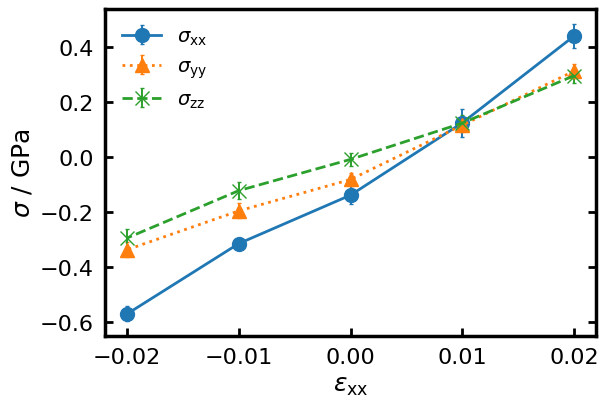

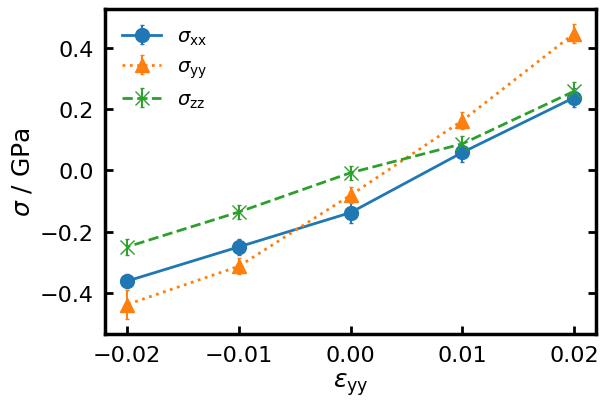

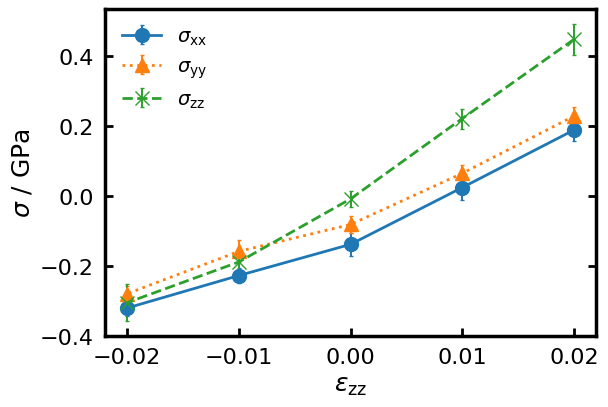

In [5]:
# Get the average pressure tensor and plot itfor each state

for (temperature,pressure), s_dict in state_dict.items():
    print(f"Temperature: {temperature:.1f} K, pressure: {pressure:.1f} bar")

    plot_deformation( s_dict["average"] )

In [6]:
# Get the mechanical properties over each copy and from it the mean and standard deviation

for (temperature, pressure), s_dict in state_dict.items():
    
    final_results = { }

    for copy, deformation_dict in s_dict.items():
        if copy == "average":
            continue

        # Get slope of stress-strain curve at low deformation 
        stiffness_tensor = get_stiffness_tensor( deformation_dict )
        
        # Computation of mechanical properties 

        # Voigt Reuss Hill
        K, G, E, nu = compute_VRH( stiffness_tensor )

        final_results[copy] = { "C": { "mean": stiffness_tensor.tolist() },
                                "K": { "mean": K },
                                "G": { "mean": G },
                                "E": { "mean": E },
                                "nu": { "mean": nu } 
                                }
    
    # Get the average over all copies
    final_results["average"] = { key: { "mean": np.mean( [ copy_data[key]["mean"] for copy_data in final_results.values() ], axis=0  ).tolist(),
                                        "std": np.std( [ copy_data[key]["mean"] for copy_data in final_results.values() ], ddof=1, axis=0  ).tolist() }  
                                 for key in ["C","K","G","E","nu"] 
                               }

    txt = f"\nState point: T = {temperature:.1f} K, p = {pressure:.1f} bar\n"
    txt += "Averaged Stiffness Tensor\n"
    txt += "\n"
    for i in range(1,7): txt += "  ".join( [ "C%d%d"%(i,j) for j in range(1,7) ] ) + "\n"
    txt += "\n"
    for i in range(0,6): txt += "  ".join( [ "%.2f ± %.2f"%(st,std) for st,std in zip( np.array(final_results["average"]["C"]["mean"])[i,:], 
                                                                                       np.array(final_results["average"]["C"]["std"])[i,:] ) ] ) + "\n"
    txt += "\n"
    txt += "\nAveraged mechanical properties with Voigt Reuss Hill: \n"
    txt += "\n"
    txt += "Bulk modulus K = %.0f ± %.0f GPa \n"%( final_results["average"]["K"]["mean"], final_results["average"]["K"]["std"] ) 
    txt += "Shear modulus G = %.0f ± %.0f GPa \n"%( final_results["average"]["G"]["mean"], final_results["average"]["G"]["std"] ) 
    txt += "Youngs modulus E = %.0f ± %.0f GPa \n"%( final_results["average"]["E"]["mean"], final_results["average"]["E"]["std"] ) 
    txt += "Poission ratio nu = %.3f ± %.3f \n"%( final_results["average"]["nu"]["mean"], final_results["average"]["nu"]["std"] ) 

    print(txt)
    
work_json( file_path = f"{lammps_setup.system_setup['folder']}/{lammps_setup.system_setup['name']}/deformation/final_results.json",
           data =  final_results,
           to_do = "write" )


State point: T = 298.1 K, p = 1.0 bar
Averaged Stiffness Tensor

C11  C12  C13  C14  C15  C16
C21  C22  C23  C24  C25  C26
C31  C32  C33  C34  C35  C36
C41  C42  C43  C44  C45  C46
C51  C52  C53  C54  C55  C56
C61  C62  C63  C64  C65  C66

24.60 ± 0.27  15.58 ± 0.16  13.48 ± 0.95  0.32 ± 0.22  -0.77 ± 0.59  -1.00 ± 0.22
15.58 ± 0.16  22.43 ± 0.84  12.39 ± 1.08  -0.09 ± 0.82  0.26 ± 0.69  -1.22 ± 0.10
13.48 ± 0.95  12.39 ± 1.08  19.16 ± 1.19  0.17 ± 0.30  0.25 ± 0.55  -0.53 ± 0.50
0.32 ± 0.22  -0.09 ± 0.82  0.17 ± 0.30  2.04 ± 0.56  0.06 ± 0.28  -0.37 ± 0.41
-0.77 ± 0.59  0.26 ± 0.69  0.25 ± 0.55  0.06 ± 0.28  2.08 ± 0.39  0.15 ± 0.61
-1.00 ± 0.22  -1.22 ± 0.10  -0.53 ± 0.50  -0.37 ± 0.41  0.15 ± 0.61  3.42 ± 0.55


Averaged mechanical properties with Voigt Reuss Hill: 

Bulk modulus K = 17 ± 1 GPa 
Shear modulus G = 3 ± 0 GPa 
Youngs modulus E = 8 ± 1 GPa 
Poission ratio nu = 0.418 ± 0.010 



In [ ]:
import pandas as pd

# Create xlsx file with tables

main_path = "./alumina/mechanical_properties/data"
phases = [ "corundum", "boehmite", "diaspore", "gamma_al2o3", "gibbsite" ]
ffs    = [ "charmm", "cvff", "pcff" ]

# 'C₁₁ [GPa]', 'C₂₂ [GPa]', 'C₃₃ [GPa]', 'C₄₄ [GPa]', 'C₁₂ [GPa]', 'C₁₃ [GPa]', 'C₁₄ [GPa]', 'K [GPa]', 'E [GPa]', 'G [GPa]', 'ν [-]'

exp_data = { "corundum": ['497', '497','501', '147', '163', '116', '22', '254', '403', '163', '0.24'],
             "gamma_al2o3": ['','','','','','','','','','','0.24 ± 0.2'],
             "gibbsite": ['','','','','','','','49','','',''],
             "diaspore": ['249','334','392','126','68','46','','','','117','0.19'],
             "boehmite": ['','','','','','','','','11','',''] }

dft_data = { "corundum": ['497','497','493','148','108','20','','','','166',''],
             "gamma_al2o3": ['','','','','','','','','','',''],
             "gibbsite": ['131','145','120','23','56','4','','','','148',''],
             "diaspore": ['','','','','','','','150','','',''],
             "boehmite": ['','','','','','','','82/97','','','']  }


with pd.ExcelWriter(f"{main_path}/results.xlsx", engine='xlsxwriter') as writer:

    for phase in phases:
            # Create a dictionary with empty lists as values
        data = {
            'IFF-CHARMM': ['','','','','','','','','',''],
            'IFF-cvff': ['','','','','','','','','',''],
            'IFF-pcff': ['','','','','','','','','',''],
            'Experimental': exp_data[phase],
            'DFT': dft_data[phase]
        }

        for i,ff in enumerate(ffs):
            json_path = f"{main_path}/{phase}/{ff}/deformation/mechanical_properties.json"

            mech = work_json( json_path )

            C,std_C   = mech["stiffness_tensor"]
            E,std_E   = mech["youngs_modulus"]
            K,std_K   = mech["bulk_modulus"]
            G,std_G   = mech["shear_modulus"]
            nu,std_nu = mech["poission_ratio"]

            data[ list(data.keys())[i] ] = [f"{C[0][0]:.0f} ± {std_C[0][0]:.0f}",
                                            f"{C[1][1]:.0f} ± {std_C[1][1]:.0f}",
                                            f"{C[2][2]:.0f} ± {std_C[2][2]:.0f}",
                                            f"{C[3][3]:.0f} ± {std_C[3][3]:.0f}",
                                            f"{C[0][1]:.0f} ± {std_C[0][1]:.0f}",
                                            f"{C[0][2]:.0f} ± {std_C[0][2]:.0f}",
                                            f"{C[0][3]:.0f} ± {std_C[0][3]:.0f}",
                                            f"{K:.0f} ± {std_K:.0f}",
                                            f"{E:.0f} ± {std_E:.0f}",
                                            f"{G:.0f} ± {std_G:.0f}",
                                            f"{nu:.2f} ± {std_nu:.2f}"]

            data[list(data.keys())[i]] = [ f"{C[0][0]:.0f}",
                                        f"{C[1][1]:.0f}",
                                        f"{C[2][2]:.0f}",
                                        f"{C[3][3]:.0f}",
                                        f"{C[0][1]:.0f}",
                                        f"{C[0][2]:.0f}",
                                        f"{C[0][3]:.0f}",
                                        f"{K:.0f}",
                                        f"{E:.0f}",
                                        f"{G:.0f}",
                                        f"{nu:.2f}"]
            
        # Create a DataFrame from the dictionary
        df = pd.DataFrame(data, index=['C₁₁ [GPa]', 'C₂₂ [GPa]', 'C₃₃ [GPa]', 'C₄₄ [GPa]', 'C₁₂ [GPa]', 'C₁₃ [GPa]', 'C₁₄ [GPa]', 'K [GPa]', 'E [GPa]', 'G [GPa]', 'ν [-]'] )

        # Save DataFrame to Excel file with subscript formatting and styling
        df.to_excel(writer, sheet_name=phase, index=True, index_label=phase)
        workbook = writer.book
        worksheet = writer.sheets[phase]

        # Add a format for the top row labels (header)
        header_format = workbook.add_format({'bg_color': '#D3D3D3', 'font_name': 'Times New Roman', 'font_size': 11, 'border': 1, 'bold': True, 'align': 'center', 'valign': 'vcenter'})  # Light grey background color
        for col_num, value in enumerate(df.columns.values):
            worksheet.write(0, col_num + 1, value, header_format)  # Apply format to each column label

        # Set font and border for the values
        value_format = workbook.add_format({'font_name': 'Times New Roman', 'font_size': 11, 'border': 1, 'align': 'center', 'valign': 'vcenter'})  # Times New Roman font with size 11 and border
        for row in range(1, df.shape[0] + 1):
            for col in range(1, df.shape[1] + 1):
                worksheet.write(row, col, df.iloc[row - 1, col - 1], value_format)

        # Set font for the index labels
        index_format = workbook.add_format({'font_name': 'Times New Roman', 'font_size': 11, 'border': 1, 'bold': True, 'align': 'center', 'valign': 'vcenter'})  # Times New Roman font with size 11, bold, and border
        for row in range(1, df.shape[0] + 1):
            worksheet.write(row, 0, df.index[row - 1], index_format)  # Apply format to each index label

        # Adjust the width of each column based on the maximum content length
        for i, col in enumerate(df.columns):
            max_len = max(df[col].astype(str).map(len).max(), len(col))
            worksheet.set_column(i + 1, i + 1, max_len + 4)  # Add a little extra space for padding

